In [1]:
import sys; sys.path.append('../')
from stanShock import dSFdx, stanShock, smoothingFunction
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time
import cantera as ct
from scipy.optimize import newton

C:\Users\Jackie Zheng\PycharmProjects\StanShock\stanShock.py:393: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "getCp_python" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(int64, dtype=Function(<class 'int'>))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'zeros': File: numba\core\typing\npydecl.py: Line 507.
    With argument(s): '(int64, dtype=Function(<class 'int'>))':
   No match.

During: resolving callee type: Function(<built-in function zeros>)
During: typing of call at C:\Users\Jackie Zheng\PycharmProjects\StanShock\stanShock.py (416)


File "..\stanShock.py", line 416:
def getCp_python(T,Y,TTable,a,b):
    <source elided>
    #determine the indices
    indices = np.zeros(nX,dtype=int)
    ^

  def getCp_python(T,Y,TTable,a,b):
C:\Users\Jackie Zheng\PycharmProjects\StanShock\stanShock.py

In [2]:
# parameters for shock ID 659
fontsize = 12
tFinal = 25e-3
p5, p1 = 101487.481415, 11652.374963
T5 = 600.919105
#g4 = g1 = 5.0/3.0 #monatomic gas in driver and driven sections
g4, g1 = 1.4294, 1.439251
W4, W1 = 23.8865, 19.9624 #Helium and argon
MachReduction = 0.985 #account for shock wave attenuation
nXCoarse, nXFine = 200, 1000 #mesh resolution
LDriver, LDriven = 3.63, 9.73
DDriver, DDriven = 1.4*(11.53e-2), 11.53e-2
plt.close("all")
mpl.rcParams['font.size']=fontsize
plt.rc('text',usetex=True)

In [3]:
xLower = -LDriver
xUpper = LDriven
xShock = 0.0
Delta = 10*(xUpper-xLower)/float(nXFine)
geometry=(nXCoarse,xLower,xUpper,xShock)
DInner = lambda x: np.zeros_like(x)
dDInnerdx = lambda x: np.zeros_like(x)
def DOuter(x): return smoothingFunction(x,xShock,Delta,DDriver,DDriven)
def dDOuterdx(x): return dSFdx(x,xShock,Delta,DDriver,DDriven)
A = lambda x: np.pi/4.0*(DOuter(x)**2.0-DInner(x)**2.0)
dAdx = lambda x: np.pi/2.0*(DOuter(x)*dDOuterdx(x)-DInner(x)*dDInnerdx(x))
dlnAdx = lambda x,t: dAdx(x)/A(x)

In [4]:
def res(Ms1):
    return p5/p1-((2.0*g1*Ms1**2.0-(g1-1.0))/(g1+1.0))\
                *((-2.0*(g1-1.0)+Ms1**2.0*(3.0*g1-1.0))/(2.0+Ms1**2.0*(g1-1.0)))
Ms1 = newton(res,2.0)
Ms1*= MachReduction
T5oT1 = (2.0*(g1-1.0)*Ms1**2.0+3.0-g1)\
       *((3.0*g1-1.0)*Ms1**2.0-2.0*(g1-1.0))\
       /((g1+1.0)**2.0*Ms1**2.0)
T1 = T5/T5oT1
a1oa4 = np.sqrt(W4/W1)
p4op1 = (1.0+2.0*g1/(g1+1.0)*(Ms1**2.0-1.0))\
       *(1.0-(g4-1.0)/(g4+1.0)*a1oa4*(Ms1-1.0/Ms1))**(-2.0*g4/(g4-1.0))
p4 = p1*p4op1

#set up the gasses
u1 = 0.0;
u4 = 0.0; #initially 0 velocity
mech = "Propane.xml" #mech="HeliumArgon.xml"
gas1 = ct.Solution(mech)
gas4 = ct.Solution(mech)
T4 = T1; #assumed
gas1.TPX = T1, p1,"C3H8:0.0309, O2:0.195, HE:0.388, N2:0.3861"#gas1.TPX = T1,p1,"AR:1"
gas4.TPX = T4,p4, "N2:0.8286, HE:0.1714"#"N2:1"#gas4.TPX = T4,p4,"HE:1"

In [5]:
boundaryConditions=['reflecting','reflecting']
state1 = (gas1,u1)
state4 = (gas4,u4)

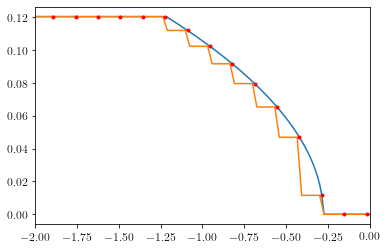

In [6]:
DIn = np.loadtxt('DInnerInsert.csv')
xIn = np.loadtxt('xInsert.csv')
x_step = 10
disX = xIn[0:-1:x_step]
disD = DIn[0:-1:x_step]
delta = 1
dx = xIn[1]-xIn[0]

def DInner_discrete(x):
    DInner_dis = np.zeros(x.shape)
    cnt = 0
    for X in x:
        if np.sum(X > np.array(disX)) < len(disD):
            DInner_dis[cnt] = disD[np.sum(X > np.array(disX))]
        cnt = cnt+1
    for d in range(0, int(np.floor(len(x)/x_step))-1):
        LowBond = int(d*x_step-delta)
        UpBond = int(d*x_step+delta)
        x_loc = x[LowBond:UpBond]
        DInner_dis[LowBond:UpBond] = smoothingFunction(x_loc, disX[d], 2*delta*dx, disD[d], disD[d+1])
    return  DInner_dis
plt.plot(xIn, DIn)#
plt.plot(xIn, DInner_discrete(xIn))#%%
plt.plot(xIn[0:-1:x_step], DIn[0:-1:x_step], 'r.')
plt.xlim((-2, 0))
def dDInnerdx_dis(x):
    dDIndx = np.zeros(x.shape)
    for d in range(0, int(np.floor(len(x)/x_step))-1):
        LowBond = int(d*x_step-delta)
        UpBond = int(d*x_step+delta)
        x_loc = x[LowBond:UpBond]
        dDIndx[LowBond:UpBond] = dSFdx(x_loc, disX[d], 2*delta*dx, disD[d], disD[d+1])
    return dDIndx
A_dis = lambda x: np.pi/4.0*(DOuter(x)**2.0-DInner_discrete(x)**2.0)
dAdx_dis = lambda x: np.pi/2.0*(DOuter(x)*dDOuterdx(x)-DInner_discrete(x)*dDInnerdx_dis(x))
dlnAdx_dis = lambda x,t: dAdx_dis(x)/A(x)

#plt.figure()
#plt.plot(xIn, )

C:\Users\Jackie Zheng\.conda\envs\p37_cantera\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()
C:\Users\Jackie Zheng\.conda\envs\p37_cantera\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Iteration: 100. Current time: 0.002446. Final time: 0.040000. Time step: 2.531255e-05.
Iteration: 200. Current time: 0.004903. Final time: 0.040000. Time step: 2.424429e-05.
Iteration: 300. Current time: 0.007342. Final time: 0.040000. Time step: 2.454283e-05.
Iteration: 400. Current time: 0.009814. Final time: 0.040000. Time step: 2.489849e-05.
Iteration: 500. Current time: 0.012317. Final time: 0.040000. Time step: 2.515652e-05.
Iteration: 600. Current time: 0.014844. Final time: 0.040000. Time step: 2.538551e-05.
Iteration: 700. Current time: 0.017401. Final time: 0.040000. Time step: 2.647401e-05.
Iteration: 800. Current time: 0.020067. Final time: 0.040000. Time step: 2.714102e-05.
Iteration: 900. Current time: 0.022828. Final time: 0.040000. Time step: 2.791027e-05.
Iteration: 1000. Current time: 0.025631. Final time: 0.040000. Time step: 2.810506e-05.
Iteration: 1100. Current time: 0.028439. Final time: 0.040000. Time step: 2.852126e-05.
Iteration: 1200. Current time: 0.031339. 

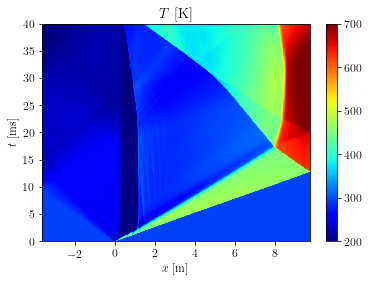

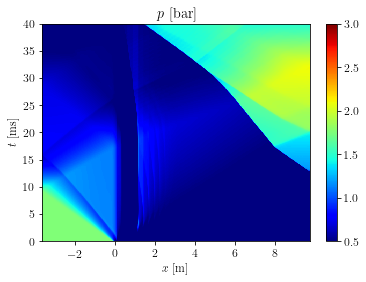

In [7]:
geometry=(nXFine,xLower,xUpper,xShock)
gas1.TPX = T1, p1,"C3H8:0.0309, O2:0.195, HE:0.388, N2:0.3861"#gas1.TPX = T1,p1,"AR:1"
gas4.TPX = T4,p4, "N2:0.8286, HE:0.1714"#"N2:1"#gas4.TPX = T4,p4,"HE:1"
ss = stanShock(gas1,initializeRiemannProblem=(state4,state1,geometry),
                   boundaryConditions=boundaryConditions,
                   cfl=.9,
                   outputEvery=100,
                   includeBoundaryLayerTerms=True,
                   Tw=T1, #assume wall temperature is in thermal eq. with gas
                   DOuter= DOuter,
                   DInner= DInner_discrete,
                   dlnAdx=dlnAdx_dis)
ss.addXTDiagram("p")
ss.addXTDiagram("T")
ss.addProbe(max(ss.x)) #end wall probe
t0 = time.clock()
ss.advanceSimulation(tFinal)
t1 = time.clock()
print("The process took ", t1-t0)
pInsert_dis = np.array(ss.probes[0].p)
tInsert_dis = np.array(ss.probes[0].t)

ss.plotXTDiagram(ss.XTDiagrams["t"],limits=[200.0,700.0])


ss.plotXTDiagram(ss.XTDiagrams["p"],limits=[0.5,3])
xInsert_dis = ss.x
DOuterInsert_dis = ss.DOuter(ss.x)
DInnerInsert_dis = ss.DInner(ss.x)

C:\Users\Jackie Zheng\.conda\envs\p37_cantera\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\Jackie Zheng\.conda\envs\p37_cantera\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


Iteration: 100. Current time: 0.002609. Final time: 0.040000. Time step: 2.543103e-05.
Iteration: 200. Current time: 0.005170. Final time: 0.040000. Time step: 2.578475e-05.
Iteration: 300. Current time: 0.007762. Final time: 0.040000. Time step: 2.599919e-05.
Iteration: 400. Current time: 0.010370. Final time: 0.040000. Time step: 2.617054e-05.
Iteration: 500. Current time: 0.012996. Final time: 0.040000. Time step: 2.634977e-05.
Iteration: 600. Current time: 0.015640. Final time: 0.040000. Time step: 2.653952e-05.
Iteration: 700. Current time: 0.018304. Final time: 0.040000. Time step: 2.673702e-05.
Iteration: 800. Current time: 0.021433. Final time: 0.040000. Time step: 3.264394e-05.
Iteration: 900. Current time: 0.024757. Final time: 0.040000. Time step: 3.381659e-05.
Iteration: 1000. Current time: 0.028244. Final time: 0.040000. Time step: 3.692635e-05.
Iteration: 1100. Current time: 0.032031. Final time: 0.040000. Time step: 3.785699e-05.
Iteration: 1200. Current time: 0.035800. 

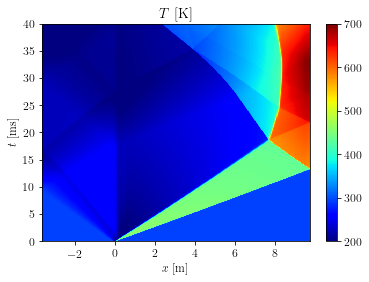

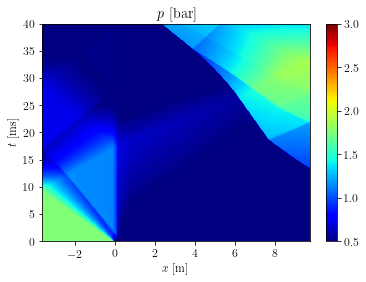

In [8]:
gas1.TPX = T1, p1,"C3H8:0.0309, O2:0.195, HE:0.388, N2:0.3861"#gas1.TPX = T1,p1,"AR:1"
gas4.TPX = T4,p4, "N2:0.8286, HE:0.1714"#"N2:1"#gas4.TPX = T4,p4,"HE:1"
ss = stanShock(gas1,initializeRiemannProblem=(state4,state1,geometry),
                   boundaryConditions=boundaryConditions,
                   cfl=.9,
                   outputEvery=100,
                   includeBoundaryLayerTerms=True,
                   Tw=T1, #assume wall temperature is in thermal eq. with gas
                   DOuter= DOuter,
                   dlnAdx= dlnAdx)
ss.addXTDiagram("p")
ss.addXTDiagram("T")
ss.addProbe(max(ss.x)) #end wall probe
t0 = time.clock()
ss.advanceSimulation(tFinal)
t1 = time.clock()
print("The process took ", t1-t0)
pNoInsert = np.array(ss.probes[0].p)
tNoInsert = np.array(ss.probes[0].t)
ss.plotXTDiagram(ss.XTDiagrams["t"],limits=[200.0,700.0])
ss.plotXTDiagram(ss.XTDiagrams["p"],limits=[0.5,3])


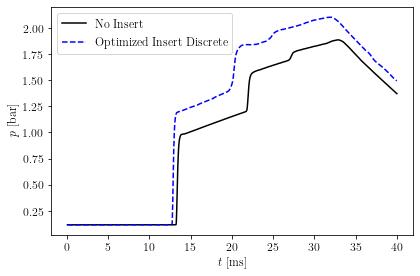

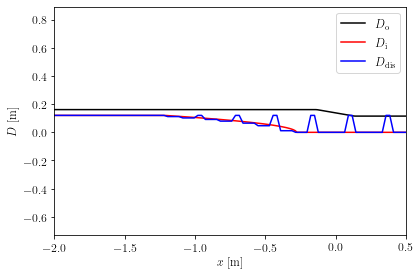

In [9]:
plt.figure()
plt.plot(tNoInsert/1e-3,pNoInsert/1e5,'k',label="$\mathrm{No\ Insert}$")
plt.plot(tInsert_dis/1e-3,pInsert_dis/1e5,'--b',label="$\mathrm{Optimized\ Insert\ Discrete}$")
plt.xlabel("$t\ [\mathrm{ms}]$")
plt.ylabel("$p\ [\mathrm{bar}]$")
plt.legend(loc="best")
plt.tight_layout()

plt.figure()
plt.axis('equal')
plt.xlim((-2, 0.5))
plt.plot(xIn,DOuter(xIn),'k',label="$D_\mathrm{o}$")
plt.plot(xIn,DIn,'r',label="$D_\mathrm{i}$")
plt.plot(xInsert_dis,DInnerInsert_dis,'b',label="$D_\mathrm{dis}$")
plt.xlabel("$x\ [\mathrm{m}]$")
plt.ylabel("$D\ [\mathrm{m}]$")
plt.legend(loc="best")
plt.tight_layout()

In [11]:
np.savetxt('tInsert_dis.csv', tInsert_dis, delimiter=',')

